# Ground Layer Adaptive Optics Reconstructor

In [1]:
import math
import numpy as np
import ceo
import yaml
import matplotlib.pyplot as plt
%matplotlib inline

GMT Atmosphere with strong turbulence near the ground

In [2]:
atm =  ceo.GmtAtmosphere(0.15,30,ID=2)

A V band on-axis source is defined first,

In [3]:
D = 25.5
NL = 48
NA = NL+1
zen = np.ones(3)*6
azi = np.arange(3)*2*np.pi/3
ngs = ceo.Source('Vs',zenith=zen*ceo.constants.ARCMIN2RAD,azimuth=azi,resolution=(NA,NA))

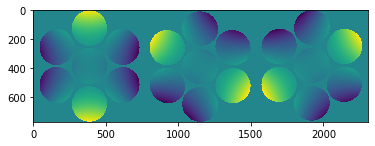

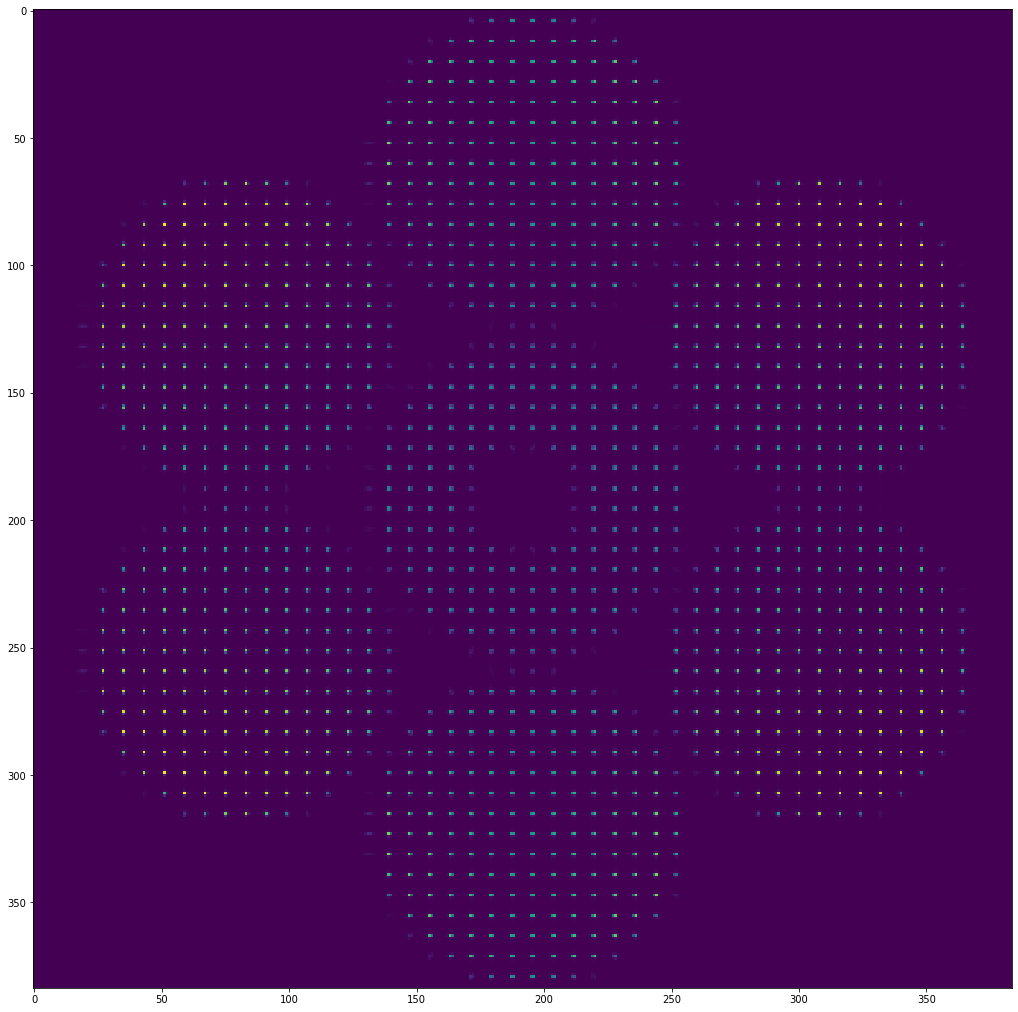

In [4]:
gmt = ceo.GMT_MX()


wfs = ceo.ShackHartmann(NL,16,D/NL,N_PX_IMAGE=24,BIN_IMAGE=3,N_GS=3)

N = NL*16+1

nngs = ceo.Source('Vs',zenith=zen*ceo.constants.ARCMIN2RAD,azimuth=azi,
                  rays_box_size=25.5,rays_box_sampling=N,rays_origin=[0,0,25])

nngs>>(gmt,)

+nngs

v2h  = lambda x : np.hstack(np.vsplit(x,3))

fig,ax = plt.subplots()
ax.imshow(v2h(nngs.phase.host()))

wfs.calibrate(nngs,0.5)

nngs>>(gmt,wfs)
+nngs

fig,ax = plt.subplots(figsize=(18,18))
ax.imshow(np.vsplit(wfs.frame.host(),3)[0])

In [5]:
wfs.pixel_scale_arcsec

0.2911973743824343

Sampling a 10' diameter field of view:

In [6]:
data = np.loadtxt("KPP_field_sampler.csv",delimiter=',',skiprows=1)
zen_sc = data[:,0]
azi_sc = data[:,1]*np.pi/180

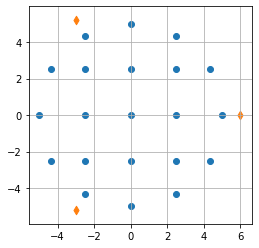

In [7]:
fig,ax = plt.subplots()
x_sc = zen_sc*np.cos(azi_sc)
y_sc = zen_sc*np.sin(azi_sc)
ax.scatter(x_sc,y_sc)
x = zen*np.cos(azi)
y = zen*np.sin(azi)
ax.scatter(x,y,marker='d')
ax.grid()
ax.set_aspect('equal')

In [8]:
src = ceo.Source('Vs',zenith=zen_sc*ceo.constants.ARCMIN2RAD,azimuth=azi_sc,resolution=(NA,NA))

In [9]:
d = D/NL
cog = ceo.Centroiding(NL,nngs.N_SRC)
tel = ceo.GMT(NL*16,D)
dm  = ceo.Mask(NA,D)
cog.fried_geometry(dm, tel, 16, 0.5)

In [10]:
dm_mask = dm.f
src.masked(dm)

In [11]:
p = D/(NA-1)
atm.get_phase_screen(src,p,NA,p,NA,0.0)
src_phase = src.phase.host(units='micron')#,zm=True,mask=dm_mask.host())

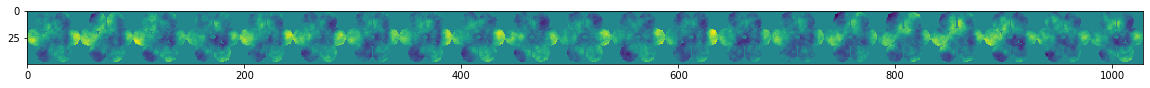

In [12]:
fig,ax=plt.subplots(figsize=(20,4))
ax.imshow(src_phase.T)

On axis wavefront:

In [13]:
src0 = ceo.Source('Vs',resolution=(NA,NA))
src0.masked(dm)
atm.get_phase_screen(src0,p,NA,p,NA,0.0)
src0_phase = src0.phase.host(units='micron',zm=True,mask=dm_mask.host())

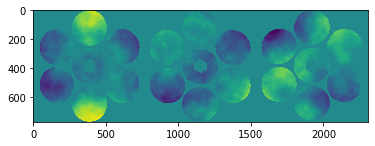

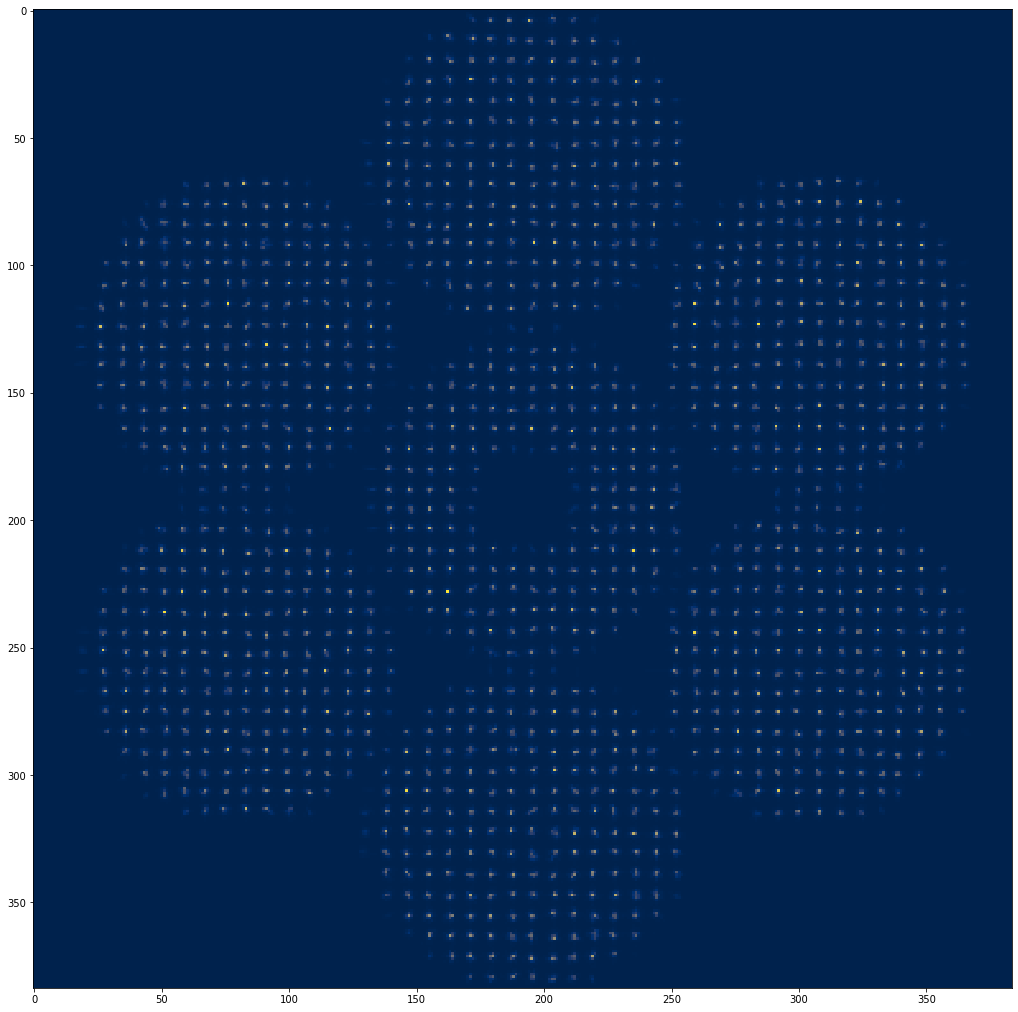

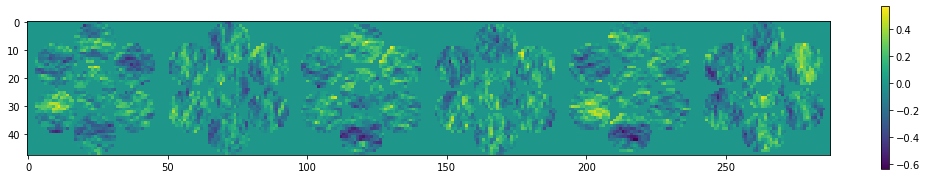

In [18]:
nngs.reset()
p = D/(N-1)
atm.get_phase_screen(nngs,p,N,p,N,0.0)
gmt.propagate(nngs)

fig,ax = plt.subplots()
plt.imshow(v2h(nngs.phase.host()))

wfs.reset()
wfs.analyze(nngs)

fig,ax = plt.subplots(figsize=(18,18))
ax.imshow(np.vsplit(wfs.frame.host(),3)[0],cmap='cividis')

cc = wfs.c.host(units='arcsec')

fig,ax = plt.subplots(figsize=(18,3))
h = ax.imshow(np.hstack(np.vsplit(cc.reshape(NL*2*ngs.N_SRC,NL),ngs.N_SRC*2)))
fig.colorbar(h,ax=ax)

In [15]:
palmmse = ceo.ALmmse(atm,ngs,ceo.constants.ARCMIN2RAD*5,d,NL,dm,"MINRES")
palmmse.estimation(wfs.data_proc)
ppalmmse_phase = palmmse.phase.host(units='micron',zm=True,mask=dm_mask.host())

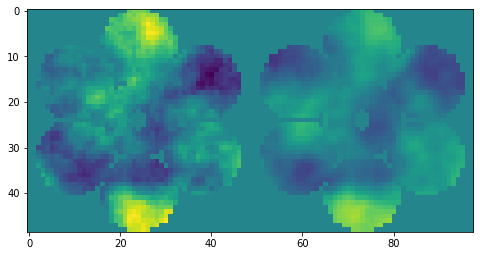

In [16]:
fig,ax = plt.subplots(figsize=(8,10))
h = ax.imshow(np.hstack([src0_phase,ppalmmse_phase]))

In [17]:
m = dm_mask.host().ravel()==1
wfe_rms = 1e3*src_phase.reshape(-1,NA*NA)[:,m].std(-1)

res_wfe_rms = 1e3*(src_phase.reshape(-1,49*49)-ppalmmse_phase.reshape(-1,NA*NA))[:,m].std(-1)

print("WFE RMS [nm]:")
print(" * before GLAO: {}".format(np.array_str(wfe_rms,precision=0)))
print(" * after GLAO: {}".format(np.array_str(res_wfe_rms,precision=0)))

WFE RMS [nm]:
 * before GLAO: [1742. 1910. 1788. 1567. 1802. 1803. 1659. 1834. 1785. 1776. 1592. 1704.
 1870. 1589. 1572. 1788. 1818. 1929. 2085. 1587. 1696.]
 * after GLAO: [ 972. 1239. 1289. 1046.  965. 1051. 1006.  939. 1022. 1054. 1027. 1027.
  982.  991. 1104. 1227. 1382. 1370. 1579. 1181. 1094.]
